In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from Churn.repos.churn.params_manager import load_params

import optuna

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from params_manager import INTERNAL_PATH

seed = 142

In [4]:
params_xgb = load_params('xbg')
params_cat = load_params('cat')

In [5]:
t = pd.read_csv(INTERNAL_PATH / 'train.csv')
t = t[t['outlier'] == 0].drop('outlier', axis=1)

X = t.drop('target', axis=1)
y = t['target']

cat_col = X.select_dtypes(include=['object']).columns.tolist()
X.shape

(63636, 167)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=seed, stratify=y)

In [7]:
predictions = []
score = []

In [8]:
for i in tqdm(params_cat):
    catboost_model = CatBoostClassifier(verbose=False, **i)
    catboost_model.fit(X_train, y_train)
    predictions.append(catboost_model.predict_proba(X_test)[:, 1])
    _score = concordance_index(y_test, catboost_model.predict_proba(X_test)[:, 1])
    score.append(_score)
    print(_score)
    print('----------------------------------------------')

  0%|          | 0/4 [00:00<?, ?it/s]

0.7810530813544267
----------------------------------------------
0.7821114376554226
----------------------------------------------
0.7786485715156092
----------------------------------------------
0.7824938311985031
----------------------------------------------


In [9]:
for i in tqdm(params_xgb):
    model_xgb = XGBClassifier(**i)
    model_xgb.fit(X_train.drop(cat_col, axis=1), y_train)
    predictions.append(model_xgb.predict_proba(X_test.drop(cat_col, axis=1))[:, 1])
    _score = concordance_index(y_test, model_xgb.predict_proba(X_test.drop(cat_col, axis=1))[:, 1])
    score.append(_score)
    print(_score)
    print('----------------------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

0.7850137805974959
----------------------------------------------
0.7833407086385668
----------------------------------------------
0.785159643291759
----------------------------------------------
0.7829644077389398
----------------------------------------------
0.7805041021127043
----------------------------------------------


In [10]:
score

[0.7810530813544267,
 0.7821114376554226,
 0.7786485715156092,
 0.7824938311985031,
 0.7850137805974959,
 0.7833407086385668,
 0.785159643291759,
 0.7829644077389398,
 0.7805041021127043]

## Creating an ensemble

In [11]:
def objective(trial):
    weights = []
    for i in range(len(predictions)):
        weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
    
    ensemble_predictions = np.average(predictions, axis=0, weights=weights)
    return concordance_index(y_test,  ensemble_predictions)

sqlite_db = "sqlite:///ensemble_sqlite.db"
study_name = "ensemble_8"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction='maximize')
study.optimize(objective, n_trials=1000)

best_weights = study.best_params

[I 2024-05-20 23:30:00,572] A new study created in RDB with name: ensemble_8
[I 2024-05-20 23:30:00,754] Trial 0 finished with value: 0.7851554345577944 and parameters: {'weight_model0': 0.8964325189046772, 'weight_model1': 0.5129158649184912, 'weight_model2': 0.7868709230820541, 'weight_model3': 0.5618756075450658, 'weight_model4': 0.18881328791489727, 'weight_model5': 0.4852370757016009, 'weight_model6': 0.12475157861799158, 'weight_model7': 0.8279307971998126, 'weight_model8': 0.891683791375057}. Best is trial 0 with value: 0.7851554345577944.
[I 2024-05-20 23:30:00,898] Trial 1 finished with value: 0.785385672347255 and parameters: {'weight_model0': 0.1832110164941987, 'weight_model1': 0.15292613057168825, 'weight_model2': 0.750297095370584, 'weight_model3': 0.5842684781938156, 'weight_model4': 0.9036340584976347, 'weight_model5': 0.3323171021890964, 'weight_model6': 0.6559938258037299, 'weight_model7': 0.42894923011119, 'weight_model8': 0.9004259390446966}. Best is trial 1 with va

In [12]:
weights = list(best_weights.values())
weights

[0.9841025675444579,
 0.5653321483794488,
 0.031323924857095724,
 4.8072240150905804e-05,
 0.9493488294221477,
 0.0008692714298056372,
 0.922893843748664,
 0.25068324136950715,
 5.4964812462169927e-05]

## ROC

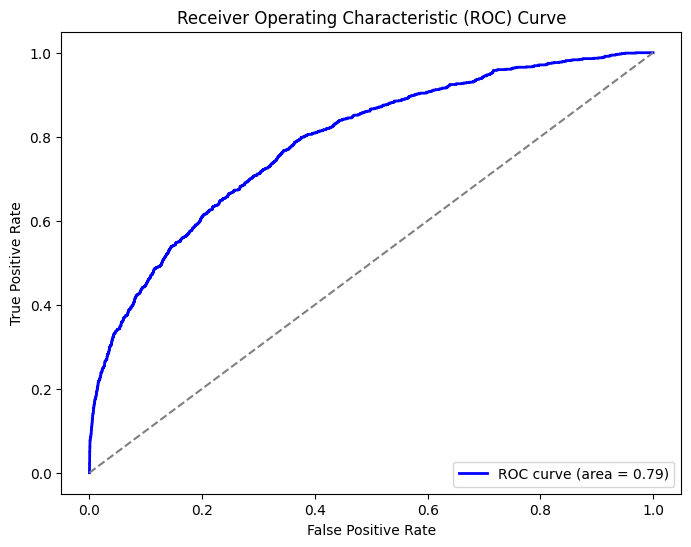

Best Threshold: 0.059766641983460204
Sensitivity (True Positive Rate) at best threshold: 0.7672897196261682
False Positive Rate at best threshold: 0.3446560301938583


In [13]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, np.average(predictions, axis=0, weights=weights))

# Calculate the area under the ROC curve (ROC AUC)
roc_auc = roc_auc_score(y_test, np.average(predictions, axis=0, weights=weights))

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Find the threshold that maximizes sensitivity and minimizes false positives
best_threshold_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_idx]
best_tpr = tpr[best_threshold_idx]
best_fpr = fpr[best_threshold_idx]

print("Best Threshold:", best_threshold)
print("Sensitivity (True Positive Rate) at best threshold:", best_tpr)
print("False Positive Rate at best threshold:", best_fpr)

## Youden's J statistic

In [14]:
# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

best_threshold_idx = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_idx]
best_tpr = tpr[best_threshold_idx]
best_fpr = fpr[best_threshold_idx]

print("Best Threshold:", best_threshold)
print("Sensitivity (True Positive Rate) at best threshold:", best_tpr)
print("False Positive Rate at best threshold:", best_fpr)

Best Threshold: 0.059766641983460204
Sensitivity (True Positive Rate) at best threshold: 0.7672897196261682
False Positive Rate at best threshold: 0.3446560301938583
